In [0]:
# -*- coding: utf-8 -*-
"""
Created on Sat May 25 17:52:17 2019

PoC models training for Smart Horse

@author: Andrzej Różyc
"""


'\nCreated on Sat May 25 17:52:17 2019\n\nPoC models training for Smart Horse\n\n@author: Andrzej Różyc\n'

# Imports Section

In [0]:

import glob
import os
import sys

#if 'plaidml' in sys.prefix:
#    os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

import pandas as pd

from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from scipy import ndimage
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.utils.np_utils import to_categorical 
from keras.callbacks import EarlyStopping

import keras 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.utils.np_utils import to_categorical 
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import seaborn as sn



Using TensorFlow backend.


# Mounting drive with data

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data reading and labeling functions

In [0]:


def read_data(filename):
    df0=pd.read_fwf(filename ,decimal=',', widths=[10,10,10,11,10,10,11,10,10], skiprows=2, header=None)
    df0.rename(inplace=True,columns={0:'ax',1:'ay',2:'az',3:'gx',4:'gy',5:'gz',6:'mx',7:'my',8:'mz'})
    df0.fillna(inplace=True, value=0.00)
    df0.replace([None], [0.00], inplace=True)
    df0 = df0.apply(pd.to_numeric)
    
    return df0
#%%

def draw_data(filename):
    df0 = read_data(filename)
    
    fig0, p0 = plt.subplots(figsize=(20, 2))
    p0.plot(df0)
    p0.legend(['ax','ay','az','gx','gy','gz','mx','my','mz'],loc='upper right')
    plt.show
    
#%%

def files_labelling_txt(path):

    files_full = glob.glob(path+'*.txt')
    
    files  = []
    horses = []
    sides  = []
    walks  = []
    dirs   = []
    mount  = []
    terr   = []
    riders = []
    health = []
    walk_types = []

    for file in files_full:
        sn=os.path.basename(file)[:-4].lower()
        files.append(sn)
        
        if 'eter' in sn:
            horses.append('eter')
        elif 'ron' in sn:
            horses.append('ron')
        elif 'atlantyk' in sn:
            horses.append('atlantyk')
        else:
            horses.append('unknown')
            
        if 'lewa' in sn:
            if 'tylna' in sn:
                sides.append('rear left')
            else:
                sides.append('front left')
        elif 'prawa' in sn:
            if 'tylna' in sn:
                sides.append('rear right')
            else:
                sides.append('front right')
        else:
            sides.append('unknown')

        if 'pas' in sn:
            mount.append('strip')
        elif 'siodlo' in sn:
            mount.append('saddle')
        elif 'siodło' in sn:
            mount.append('saddle')
        elif 'noga' in sn:
            mount.append('leg')
        elif 'tylna' in sn or 'lewa' in sn or 'prawa' in sn:
            mount.append('leg')
        else:
            mount.append('saddle')
        
        w=[]
        if 'klus' in sn or 'kłus' in sn:
            w.append('trot')
        if 'stęp' in sn or 'step' in sn:
            w.append('walk')
        if 'galop' in sn:
            w.append('gallop')
        if len(w)==0:
            w.append('uknown')            
        walks.append(w)

        w=[]
        if 'angles' in sn:
            w.append('posting')
        if 'polsiad' in sn or 'pólsiad' in sn or 'półsiad' in sn or 'połsiad' in sn:
            w.append('half-seat')
        if 'pełny siad' in sn or 'pelny siad' in sn:
            w.append('full-seat')
        if len(w)==0:
            w.append('uknown')            
        walk_types.append(w)

        
        d=[]
        if 'lewo' in sn:
            d.append('left')
        if 'prawo' in sn:
            d.append('right')
        if len(d)==0:
            d.append('uknown')            
        dirs.append(d)
        
        t=[]
        if 'ujeżdżalnia' in sn:
            t.append('subsoil')
        if 'ujeżdzalnia' in sn:
            t.append('subsoil')
        if 'ujezdżalnia' in sn:
            t.append('subsoil')
        if 'ujezdzalnia' in sn:
            t.append('subsoil')
        if 'beton' in sn:
            t.append('concrete')
        if 'zamar' in sn:
            t.append('frozen')
        if 'zmro' in sn:
            t.append('frozen')
        if 'łąka' in sn:
            t.append('terrain')
        if 'wycieczka' in sn:
            t.append('terrain')
        if 'magdalen' in sn:
            t.append('terrain')
        if 'szarż' in sn:
            t.append('terrain')
        if 'las' in sn:
            t.append('terrain')
        if 'ubita ziemia' in sn:
            t.append('hard terrain')
        if len(t)==0:
            t.append('uknown')            
        terr.append(t)
                    
        if 'ju' in sn:
            riders.append('Julek')
        elif 'ar' in sn:
            riders.append('Arek')
        elif 'ola' in sn:
            riders.append('Ola')
        elif 'marta' in sn:
            riders.append('Marta')
        elif 'marta' in sn:
            riders.append('Agata')
        else:
            riders.append('unknown')

        if 'kuleje' in sn:
            health.append('limp')
        elif 'zdrowszy' in sn:
            health.append('light limp')
        elif 'zdrowy' in sn:
            health.append('healthy')
        else:
            health.append('unknown')

    return files_full, files, horses, sides, walks, dirs, mount, terr, riders, walk_types, health

#%%

def files_labelling_cat(path):

    files_full = glob.glob(path+'*.txt')
    
    files  = []
    horses = []
    sides  = []
    walks  = []
    dirs   = []
    mount  = []
    terr   = []
    riders = []
    health = []
    walk_types = []

    for file in files_full:
        sn=os.path.basename(file)[:-4].lower()
        files.append(sn)
        
        if 'eter' in sn:
            horses.append(1)
        elif 'ron' in sn:
            horses.append(2)
        elif 'atlantyk' in sn:
            horses.append(3)
        else:
            horses.append(0)
            
        if 'lewa' in sn:
            if 'tylna' in sn:
                sides.append(1)
            else:
                sides.append(2)
        elif 'prawa' in sn:
            if 'tylna' in sn:
                sides.append(3)
            else:
                sides.append(4)
        else:
            sides.append(0)

        if 'pas' in sn:
            mount.append(1)
        elif 'siodlo' in sn:
            mount.append(2)
        elif 'siodło' in sn:
            mount.append(2)
        elif 'noga' in sn:
            mount.append(3)
        elif 'tylna' in sn or 'lewa' in sn or 'prawa' in sn:
            mount.append(3)
        else:
            mount.append(1)
        
        w=[]
        if 'stęp' in sn or 'step' in sn:
            w.append(1)
        if 'klus' in sn or 'kłus' in sn:
            w.append(2)
        if 'galop' in sn:
            w.append(3)
        if len(w)==0:
            w.append(0)            
        walks.append(w)

        w=[]
        if 'angles' in sn:
            w.append(1)
        if 'polsiad' in sn or 'pólsiad' in sn or 'półsiad' in sn or 'połsiad' in sn:
            w.append(2)
        if 'pełny siad' in sn or 'pelny siad' in sn:
            w.append(3)
        if len(w)==0:
            w.append(0)            
        walk_types.append(w)

        
        d=[]
        if 'lewo' in sn:
            d.append(1)
        if 'prawo' in sn:
            d.append(2)
        if len(d)==0:
            d.append(0)            
        dirs.append(d)
        
        t=[]
        if 'ujeżdżalnia' in sn:
            t.append(1)
        if 'ujeżdzalnia' in sn:
            t.append(1)
        if 'ujezdżalnia' in sn:
            t.append(1)
        if 'ujezdzalnia' in sn:
            t.append(1)
        if 'beton' in sn:
            t.append(2)
        if 'zamar' in sn:
            t.append(3)
        if 'zmro' in sn:
            t.append(3)
        if 'łąka' in sn:
            t.append(4)
        if 'wycieczka' in sn:
            t.append(4)
        if 'magdalen' in sn:
            t.append(4)
        if 'szarż' in sn:
            t.append(4)
        if 'las' in sn:
            t.append(4)
        if 'ubita ziemia' in sn:
            t.append(5)
        if len(t)==0:
            t.append(0)            
        terr.append(t)
                    
        if 'ju' in sn:
            riders.append(1)
        elif 'ar' in sn:
            riders.append(2)
        elif 'ola' in sn:
            riders.append(3)
        elif 'marta' in sn:
            riders.append(4)
        elif 'agata' in sn:
            riders.append(5)
        else:
            riders.append(0)

        if 'kuleje' in sn:
            health.append(1)
        elif 'zdrowszy' in sn:
            health.append(2)
        elif 'zdrowy' in sn:
            health.append(3)
        else:
            health.append(0)
    
    return files_full, files, horses, sides, walks, dirs, mount, terr, riders, walk_types, health



# Walks recognition - KMeans

In [0]:
def walks_recognition(filename, gauss_ratio=800, clusters=0):
    
    #reading data
    
    df = read_data(filename)
    
    X=np.array(df)

    print('')
    print('Input data:')

    # drawing raw data
    fig0, px = plt.subplots(figsize=(20, 2))
    px.plot(X[:,0], label='X acc')
    px.plot(X[:,1], label='Y acc')
    px.plot(X[:,2], label='Z acc')
    px.grid(True)
    px.set_title('Raw data from accelerometers')
    px.legend()
    plt.show()

    # Data preprocessing

    # calculating absolute values from accelerometers
    #X = np.abs(X[20000:-20000,:]) #without first  and last 20000 observations
    X = np.abs(X) 

    # smoothing time series values using Gaussian filter
    X[:,0]=ndimage.filters.gaussian_filter(X[:,0],gauss_ratio, mode='reflect')
    X[:,1]=ndimage.filters.gaussian_filter(X[:,1],gauss_ratio, mode='reflect')
    X[:,2]=ndimage.filters.gaussian_filter(X[:,2],gauss_ratio, mode='reflect')

    # Normalizing input data
    scalerX=MinMaxScaler(feature_range=(0, 1))
    scalerX.fit(X)
    X=scalerX.transform(X)

    # drawing data afer preprocessing
    fig01, ppx = plt.subplots(figsize=(20, 2))
    ppx.plot(X[:,0], label='X acc')
    ppx.plot(X[:,1], label='Y acc')
    ppx.plot(X[:,2], label='Z acc')
    ppx.grid(True)
    ppx.set_title('Preprocessed data from accelerometers')
    ppx.legend()
    plt.show()

    # Optimizing numer of clusters 

    # looking for optimal number of clusters using unsupervised learning (k-means clustering)
    Sum_of_squared_distances = []
    K = np.array(list(range(1,11))) #array of possible number of clusters

    if clusters==0:
        print('')
        print('Number of clusters optimisation:')
        print('')
        for k in K:
            print("Calculating clustering for %d clusters" % k )
            km = KMeans(n_clusters=k, random_state=3).fit(X)
            Sum_of_squared_distances.append(km.inertia_)

        #Normalizing sum of squared distances array
        ss=np.zeros((len(K),2),dtype=float)
        ss[:,0]=K #x
        ss[:,1]=Sum_of_squared_distances #y
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaler.fit(ss)
        ss=scaler.transform(ss)

        #Calculating derivative (we are looking for point with derivative closest to -1) 
        dx=ss[1,0] #dx is the same for each points
        ssd=np.gradient(ss[:,1],dx)

        figsd, ssdp = plt.subplots(figsize=(5, 5))
        ssdp.scatter(ss[:,0], ssd, label='Derivative')

        ssdz=np.abs(ssd+1)
        opt_clusters=np.argmin(ssdz)+1

        ssdp.scatter(ss[opt_clusters-1,0],ssd[opt_clusters-1],c='r', marker='o', label='Optimal point')

        ssdp.grid(True)
        ssdp.set_title('Normalized squared distances derivative')
        ssdp.set_xlabel('Normalized number of clusters')
        ssdp.set_ylabel('Normalized squared distances derivative')
        ssdp.legend()

        plt.show()

        print('')
        print('Optimal number of clusters:', opt_clusters)
    else:
        opt_clusters=clusters
    
    
    # Clustering model for optimal number of clusters - recognizing horse walks in the data

    # creating model using unsupervised learning (k-means clustering) for optimal number of clusters
    kmeans = KMeans(n_clusters=opt_clusters, random_state=3).fit(X)

    print('')
    print('Horse walks recognition model:')

    # drawing cluster labels
    fig2, hx = plt.subplots(figsize=(20, 2))
    hx.plot(kmeans.labels_)
    hx.grid(True)
    hx.set_title('Walks clusters')
    hx.set_xlabel('Time')
    plt.show()

    # drawing x acc, colors: clusters
    fig3, ax = plt.subplots(figsize=(20, 2))
    ax.scatter(list(range(0,X.shape[0])),X[:,0], c=kmeans.labels_, label='X acc')
    ax.scatter(list(range(0,X.shape[0])),X[:,1], c=kmeans.labels_, label='Y acc')
    ax.scatter(list(range(0,X.shape[0])),X[:,2], c=kmeans.labels_, label='Z acc')
    #ax.scatter(list(range(0,X.shape[0])),X, c=kmeans.labels_, label='Z acc')
    ax.grid(True)
    ax.set_title('Processed acc data with recognized walks')
    ax.set_xlabel('Time')
    plt.show()

    # drawing x,y,z acc, colors: clusters
    fig6 = plt.figure(figsize=(10,10)) 
    sc = fig6.add_subplot(111, projection='3d')
    #av=np.mean(X[:,0:3], axis=1)
    sc.scatter(X[:,2],X[:,1],X[:,0], c=kmeans.labels_, marker='o', alpha=0.5)

    sc.set_xlabel('X acc')
    sc.set_ylabel('Y acc')
    sc.set_zlabel('Z acc')
    sc.set_title('Processed acc data - 3D trajectories')
    plt.show




Input data:


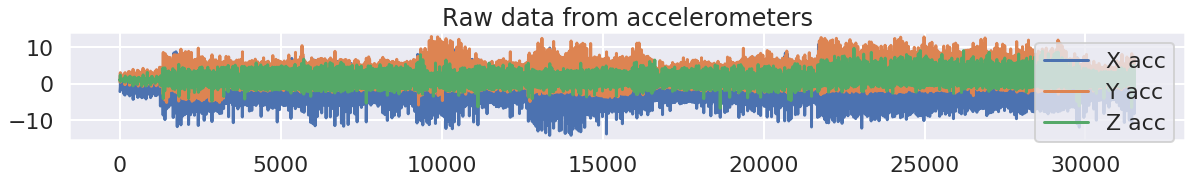

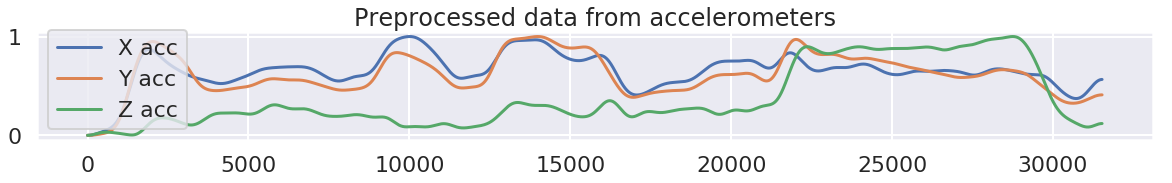


Horse walks recognition model:


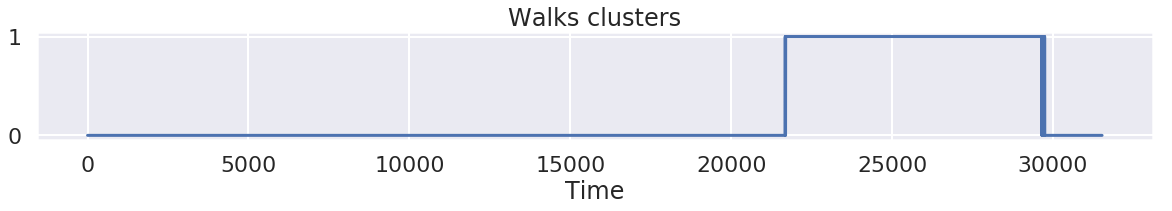

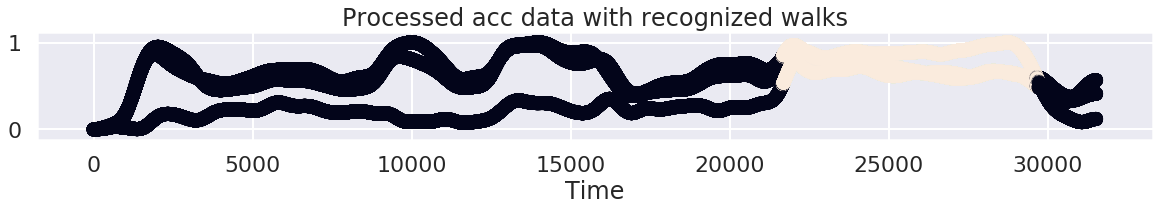

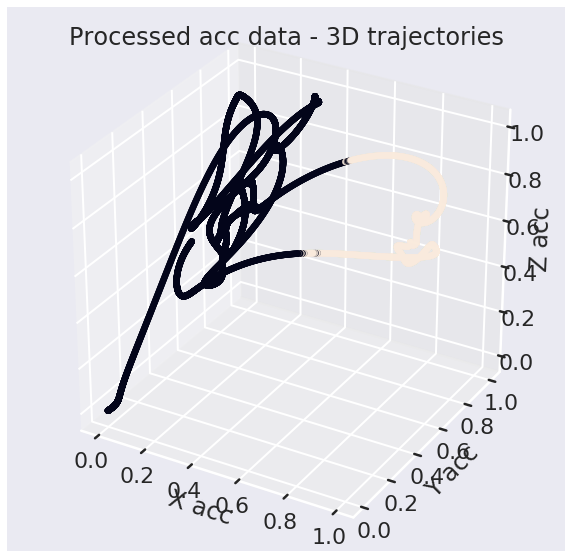

In [0]:
walks_recognition('drive/My Drive/SmartHorse/PoC Data/Horses/20181114_lewa_noga_Eter_ujezdzalnia_Ju_klus i galop.txt',gauss_ratio=300, clusters=2)

# CNN Models - generic for PoC horses data from WitMotion

In [0]:
#@title Default title text

#%% Generic model for horses - creation and training

# data_path='/users/andrzej/desktop/ron/'
# data_path='/users/andrzej/desktop/horses/'
# y_col: 2-horses, 3-sides, 4-walks, 5-dirs, 6-mount, 7-terr, 8-riders, 9-walk_types, 10-health
# model_filename='/users/andrzej/desktop/horse models/health_rec.mod'

def horse_model(data_path, y_col, model_filename,  chunk_size=1000, chunk_move=100):
    
    # Analyze data file names and labelling
    files_cat=files_labelling_cat(data_path)
        
    # Getting filen names
    files=files_cat[0]
    
    # Change labels to categorical vactors
    ilb = to_categorical(files_cat[y_col])
    
    # Preparing X and y matrix 
    X=[]
    y=[]
    i=0
    for file in files:
        print(file)
        df=read_data(file)
        arr=np.array(df)
        for ch_start in range(0,arr.shape[0]-chunk_size,chunk_move):
            X.append(arr[ch_start:ch_start+chunk_size])  
            y.append(ilb[i])
        i+=1
    
    Xarr=np.array(X)
    Xarr = Xarr.reshape(-1, Xarr.shape[1], Xarr.shape[2], 1) #reshaping to 4 dims for 2d CNN network
    yarr=np.array(y)
    
    # Splitting data to train and test data sets
    x_train, x_test, y_train, y_test = train_test_split(Xarr, yarr, test_size=0.25, random_state=42)    
    
    # Model creation 
    
    model_er = Sequential()
    model_er.add(Conv2D(128, (40, 9), input_shape=(Xarr.shape[1], Xarr.shape[2], Xarr.shape[3])))
    model_er.add(MaxPooling2D(pool_size=(4, 1)))
    model_er.add(Conv2D(64, (4, 1), activation='relu'))
    model_er.add(MaxPooling2D(pool_size=(2, 1)))
    model_er.add(Flatten())
    model_er.add(Dense(ilb.shape[1], activation='softmax'))
    
    opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
    model_er.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    # Model training
    
    early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=2, mode='auto', baseline=None, restore_best_weights=True)
    cnnhistory = model_er.fit(x_train, y_train, batch_size=32, epochs=100, validation_data=(x_test, y_test), callbacks=[early_stop])
    
    # Model saving
    
    model_er.save(model_filename)
    
    # Plotting training history 
    
    plt.plot(cnnhistory.history['loss'])
    plt.plot(cnnhistory.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    # Plotting confusion matrix 
    
    y_pred = model_er.predict(x_test)
    
    print('')    
    
    cm=[]
    for i in range(1,y_pred.shape[1]):
        cmx=confusion_matrix(y_test[:,i],y_pred[:,i].round(0))
        cm.append(cmx)
        print(cmx)
        df_cm = pd.DataFrame(cmx, range(2), range(2))
        plt.figure(figsize=(5,4))
        sn.set(font_scale=1.4)
        sn.heatmap(df_cm, annot=False)
        sn.set_context("poster")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.show()



drive/My Drive/SmartHorse/PoC Data/Horses/20181114_lewa_noga_Eter_ujezdzalnia_Ju_klus i galop.txt
drive/My Drive/SmartHorse/PoC Data/Horses/20190524_eter ląża_lewa_tylna_kłus_wlewo_wprawo_Marta_na_oklep.txt
drive/My Drive/SmartHorse/PoC Data/Horses/20190524_eter spirala_w_lewo_prawa_przednia_klus.txt
drive/My Drive/SmartHorse/PoC Data/Horses/eter galop tylna lewa w prawo i w lewo.txt
drive/My Drive/SmartHorse/PoC Data/Horses/eter Klus angles tylna lewa w prawo i w lewo.txt
drive/My Drive/SmartHorse/PoC Data/Horses/eter Klus angles w lewo potem w prawo przednia lewa noga.txt
drive/My Drive/SmartHorse/PoC Data/Horses/eter Klus angles w lewo potem w prawo przednia prawa noga.txt
drive/My Drive/SmartHorse/PoC Data/Horses/eter klus angles Tylna prawa w prawo i w lewo.txt
drive/My Drive/SmartHorse/PoC Data/Horses/eter galop tylna prawa w prawo i w lewo.txt
drive/My Drive/SmartHorse/PoC Data/Horses/20190524_eter ląża_w prawo i lewo kłusem__lewa_przednia.txt
drive/My Drive/SmartHorse/PoC Data/

W0714 15:56:40.826642 140213253076864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0714 15:56:40.863361 140213253076864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0714 15:56:40.872767 140213253076864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0714 15:56:40.912884 140213253076864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0714 15:56:40.986137 140213253076864 deprecation_wrapp

Train on 31610 samples, validate on 10537 samples
Epoch 1/100
31610/31610 [==============================] - 23s 726us/step - loss: 1.4990 - acc: 0.6867 - val_loss: 0.9923 - val_acc: 0.7461
Epoch 2/100
31610/31610 [==============================] - 18s 567us/step - loss: 0.8104 - acc: 0.7587 - val_loss: 0.7089 - val_acc: 0.7873
Epoch 3/100
31610/31610 [==============================] - 18s 569us/step - loss: 0.5472 - acc: 0.8146 - val_loss: 0.5241 - val_acc: 0.8304
Epoch 4/100
31610/31610 [==============================] - 18s 559us/step - loss: 0.3811 - acc: 0.8659 - val_loss: 0.4353 - val_acc: 0.8482
Epoch 5/100
31610/31610 [==============================] - 17s 549us/step - loss: 0.2718 - acc: 0.9013 - val_loss: 0.3158 - val_acc: 0.9031
Epoch 6/100
31610/31610 [==============================] - 17s 551us/step - loss: 0.2012 - acc: 0.9288 - val_loss: 0.2527 - val_acc: 0.9246
Epoch 7/100
31610/31610 [==============================] - 17s 545us/step - loss: 0.1526 - acc: 0.9456 - val_l

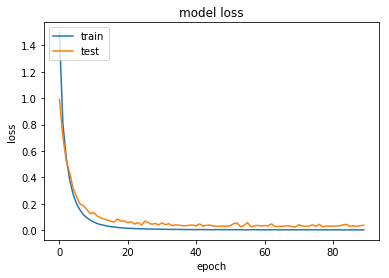


[[2492   25]
 [  31 7989]]


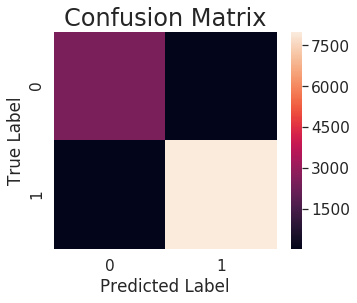

[[9537   24]
 [  20  956]]


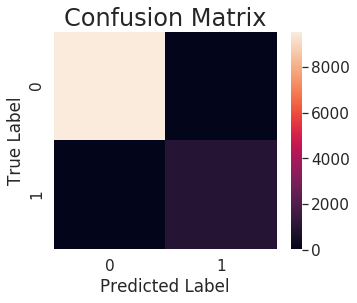

[[8989    7]
 [   5 1536]]


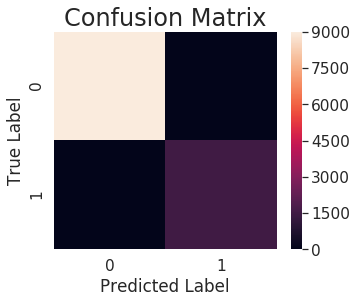

In [0]:
# model for horses recognition

horse_model('drive/My Drive/SmartHorse/PoC Data/Horses/', 2, 'drive/My Drive/SmartHorse/PoC Data/Horse Models/horses_recognition.mod',  chunk_size=1000, chunk_move=100)
